In [212]:
import numpy as np
import pandas as pd
import requests


from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()

import matplotlib
from matplotlib.pylab import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib inline 


# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

import seaborn as sns

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.7f}'.format

In [213]:
# from terra_sdk.client.lcd import LCDClient
# terra = LCDClient(chain_id="columbus-5", url="https://columbus-lcd.terra.dev")
# terra

In [214]:
# get Market Module Parameters
# terra.market.parameters()
# terra.market.terra_pool_delta()
# terra.market.swap_rate()

# get current Excahnge rates as provided by the Oracle
# terra.oracle.exchange_rates()

# terra.ibc.parameters()
# terra.ibc_transfer.parameters()



In [215]:
# import requests
# pr = requests.get('https://fcd.terra.dev/v1/market/price?denom=uusd&interval=1h').json()

In [216]:
# imageio.plugins.ffmpeg.download()
# # pip install imageio==2.4.1

In [217]:
# pip install imageio==2.4.1
# pip3 install --upgrade imageio-ffmpeg

# Introduction


## Terra’s Mission 

Terra was created with the goal to power the innovation of money by building a price-stable cryptocurrency that can be used as a means of payment and store of value at a global scale. 

The Terra protocol acted as an algorithmic entity (the de-central bank) that is responsible for maintaining this peg. 


## How Terra worked under the hood ? 

To achieve this, it implemented the underlying Luna <> Terra coins mint / burn algorithm within the core protocol via the [market module](https://github.com/terra-money/classic-core/tree/main/x/market/spec). The underlying swaps were processed in International Monetary Fund’s  Special Drawing Rights (SDR), which is a basket of multiple currencies with the official SDR rate published by the IMF on a daily basis, allowing arbitragers, market makers, and Terra to closely align the exchange rate to the peg.

The mint / burn swap mechanism is implemented as a constant Product market-making algorithm and was aimed to be designed as a function of the parity between the off-chain liquidity of LUNA/UST and the on-chain liquidity parameters for the redemption of UST/LUNA. However, it failed to behave as expected triggering a “death spiral” bank run characteristic of traditional endogenous collateral models. You can refer to research article for Jump crypto covering the terra crash more in detail [here](https://jumpcrypto.com/the-depegging-of-ust/).




## Understanding Terra's Market Module

The **base market** starts out with two liquidity pools of equal sizes, 

- one representing Terra Stablecoins (all denominations), represented by `terra_pool` parameter
- ananother representing Luna, represented by `luna_pool` parameter


The **base market** is initialized by the parameter `BasePool` (denominated in [SDR](https://en.wikipedia.org/wiki/Special_drawing_rights) ), which defines the initial size of the Terra and Luna liquidity pools.

- The `base_pool` parameter is currently set to `100000000000000`, representing 100 Million SDR. 

Any market swap between Luna <> Terra stablecoins leads to a state transition of their `total_supply` parameter value based via the `mint` / `burn` functions, and this net transition is effectively also captured in the number variable `delta` which tracks net change in the sizes of the two pools, representing the deviation of the Terra pool from its base size in units µSDR.


### Swap Procedure

1. Market module receives `MsgSwap` message and performs basic validation checks

2. Calculate ask and spread using `k.ComputeSwap()`

3. Update TerraPoolDelta with `k.ApplySwapToPool()`

4. Transfer OfferCoin from account to module using `supply.SendCoinsFromAccountToModule()`

5. Burn offered coins, with `supply.BurnCoins()`.

6. Let `fee = spread * ask`, this is the `spread fee`.

7. Mint `ask - fee coins` of AskDenom with `supply.MintCoins()`. This implicitly applies the spread fee as the fee coins are burned.

8. Send newly minted coins to trader with `supply.SendCoinsFromModuleToAccount()`

9. Emit swap event to publicize swap and record spread fee


At the end of each block, the market module will attempt to "replenish" the pools by decreasing the magnitude of between the Terra and Luna pools. The rate at which the pools will be replenished toward equilibrium is set by the parameter `PoolRecoveryPeriod`, with lower periods meaning lower sensitivity to trades, meaning previous trades are more quickly forgotten and the market is able to offer more liquidity.

This mechanism ensures liquidity and acts as a sort of low-pass filter, allowing for the `spread fee` (which is a function of `TerraPoolDelta`) to drop back down when there is a change in demand, hence necessary change in supply which needs to be absorbed.

#### Seigniorage
For Luna swaps into Terra, the Luna that recaptured by the protocol is burned and is called seigniorage -- the value generated from issuing new Terra. At the end of the epoch, the total seigniorage for the epoch will be calculated and reintroduced into the economy as ballot rewards for the exchange rate oracle and to the community pool by the Treasury module, described more fully [here](https://github.com/terra-money/classic-core/blob/main/x/treasury/spec/README.md).


Jump crypto has been tracking the performance of the market module params and recommending updates via Governance as visible via the proposals here. Brief pointers from each proposal are mentioned here - 


1. [**Jan 21 → Proposal to update market module parameters by Jump crypto**](https://classic-agora.terra.money/t/terra-on-chain-liquidity-parameters/305). 

    This proposal was followed by another one by Do Kown [here](https://classic-agora.terra.money/t/tip-36-further-improvements-to-liquidity-parameters/372) proposing further increasing market module's parameters to `Basepool 7M → 13M SDT` `PoolRecoveryPeriod 200 → 130 blocks` which will roughly terra's stablecoin minting capacity. 



2. [**May 21 →  Proposal by Jump crypto to update market module parameters**](https://classic-agora.terra.money/t/liquidity-parameters-2/1175)

     Jump briefly discussed the oraclre attack possible to be executed on terra in-case on chain liquidity driven off the oracle price is larger than liquidity off chain. Short mention on how one possible solution to mitigate this can be splitting out the `TerraPoolDelta` parameter into `TerraPoolDeltaBid` and `TerraPoolDeltaAsk`. 
    Proposed parameter updates were the following - 

    - Increase BasePool size to 32,500,000 SDR
    - Reduce PoolRecoveryPeriod to 49 blocks
    - Split out TerraPoolDelta into TerraPoolDeltaBid and TerraPoolDeltaAsk.



3. [**Jan 29, 2022 →  Proposal by Jump crypto to update market module parameters**](https://classic-agora.terra.money/t/liquidity-parameters-3/3895)

    Proposed parameter updates were the following - 

    - Increase BasePool size to 50,000,000 SDR
    - Reduce PoolRecoveryPeriod to 36 blocks


5. [**Jan 29, 2022 →  Proposal by Jump crypto for BTC reserve pools**](https://classic-agora.terra.money/t/bitcoin-reserve-pool/5259/23) --> Most of the BTC accumulated for deploying the BTC reserve pool was sold during the May, 22 crash and is not relevent for our analysis. 


## Simulated Analysis of Terra Classic's May 2022 Crash

This notebook contains busines logic for analyzing how terra classic's market module operated during the May 2022 crash.

- To do this, we have implemented terra's market module, oracle module and bank module as separate python classes. 

For simulation purposes, we have taken average of provided oracle pricefeeds per block by validators (not taking into account their vote share) and used the average price as exchange rates for computing simulated swaps until the next oracle updates are provided. (Generally after 4-5 blocks)

- **UST's price in USD** : We have used the provided oracle exchange rates and LUNA <> UST swaps via Astroport data to calculate UST's actual price in USD terms via the following formula, 

                UST's price in USD = uusd exchange rate provided via oracle / UST per Luna traded on astroport


**Note - We only look into LUNA <> UST market swaps for our analysis.**




### Import dataset

1. Import all cleaned data files 

- **aggregated_exchange_rate_vote_txs_DF** : Contains averaged oracle prices as provided by validators during per block 
- **market_swap_txs_DF** : Contains mainnet txs involving Luna <> UST swaps via Terra's Market module
- **astroport_ust_luna_txs_DF** : Contains mainnet txs involving Luna <> UST swaps via Astroport
- **aggregated_market_swap_txs_DF** : Contains total UST / LUNA which got minted / burnt per block


In [228]:
# Get DataFrames from pre-processed .csv files

## Oracle prices dataset
aggregated_exchange_rate_vote_txs_DF = pd.read_csv("./cleaned_data/aggregated_exchange_rate_vote_txs_DF.csv") 

## LUNA <> UST Swaps via Astroport dataset
astroport_ust_luna_txs_DF = pd.read_csv("./cleaned_data/astroport_ust_luna_txs_DF.csv") 

## LUNA <> UST Market Module swaps which involve mint / burn
market_swap_txs_DF = pd.read_csv("./cleaned_data/market_swap_txs_DF.csv") 

## Market Swaps via Module :: Aggregated Trading Volumes / Supply contraction / expansion dynamics
aggregated_market_swap_txs_DF = pd.read_csv("./cleaned_data/aggregated_market_swap_txs_DF.csv") 


# Remove index column
aggregated_exchange_rate_vote_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)
astroport_ust_luna_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)
aggregated_market_swap_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)
market_swap_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)




**Data Cleaning :: Step 1 - Filter data for only common blocks**

In [230]:
# Get Block heights for which data is available and block height range for which simulation is to be executed

astroport_txs_DF_start_block = astroport_ust_luna_txs_DF.iloc[0]["BlockHeight"]
astroport_txs_DF_end_block = astroport_ust_luna_txs_DF.iloc[len(astroport_ust_luna_txs_DF.index) - 1]["BlockHeight"]
print(f"astroport_txs_DF || Start block = {astroport_txs_DF_start_block}  End block = {astroport_txs_DF_end_block} \
Total Blocks = {astroport_txs_DF_end_block - astroport_txs_DF_start_block}")

aggregated_market_swap_txs_DF_start_block = aggregated_market_swap_txs_DF.iloc[0]["BlockHeight"]
aggregated_market_swap_txs_DF_end_block = aggregated_market_swap_txs_DF.iloc[len(aggregated_market_swap_txs_DF.index) - 1]["BlockHeight"]
print(f"aggregated_market_swap_txs_DF || Start block = {aggregated_market_swap_txs_DF_start_block}  End block = {aggregated_market_swap_txs_DF_end_block} \
Total Blocks = {aggregated_market_swap_txs_DF_end_block - aggregated_market_swap_txs_DF_start_block}")

market_swap_txs_DF_start_block = market_swap_txs_DF.iloc[0]["BlockHeight"]
market_swap_txs_DF_end_block = market_swap_txs_DF.iloc[len(market_swap_txs_DF.index) - 1]["BlockHeight"]
print(f"market_swap_txs_DF || Start block = {market_swap_txs_DF_start_block}  End block = {market_swap_txs_DF_end_block} \
Total Blocks = {market_swap_txs_DF_end_block - market_swap_txs_DF_start_block}")

oracle_txs_DF_start_block = aggregated_exchange_rate_vote_txs_DF.iloc[0]["BlockHeight"]
oracle_txs_DF_end_block = aggregated_exchange_rate_vote_txs_DF.iloc[len(aggregated_exchange_rate_vote_txs_DF.index) - 1]["BlockHeight"]
print(f"oracle_txs_DF || Start block = {oracle_txs_DF_start_block}  End block = {oracle_txs_DF_end_block} \
Total Blocks = {oracle_txs_DF_end_block - oracle_txs_DF_start_block}")

start_block = int(max(astroport_txs_DF_start_block, max(market_swap_txs_DF_start_block, oracle_txs_DF_start_block)))
start_block = int(max(start_block, aggregated_market_swap_txs_DF_start_block))
end_block = int(min(astroport_txs_DF_end_block, min(market_swap_txs_DF_end_block, oracle_txs_DF_end_block)))
end_block = int(min(end_block, aggregated_market_swap_txs_DF_end_block))
print(f"\nCommon Range, Start block = {start_block} End block = {end_block} | Total blocks = {end_block - start_block}")



astroport_txs_DF || Start block = 7413174  End block = 7622720 Total Blocks = 209546
aggregated_market_swap_txs_DF || Start block = 6960461.0  End block = 7595342.0 Total Blocks = 634881.0
market_swap_txs_DF || Start block = 6960461  End block = 7608047 Total Blocks = 647586
oracle_txs_DF || Start block = 6958375.0  End block = 7608054.0 Total Blocks = 649679.0

Common Range, Start block = 7413174 End block = 7595342 | Total blocks = 182168


In [231]:
# Shorten dataset for faster execution by taking only dataset for only common blocks
aggregated_exchange_rate_vote_txs_DF = aggregated_exchange_rate_vote_txs_DF.loc[(aggregated_exchange_rate_vote_txs_DF['BlockHeight'] >= start_block) & (aggregated_exchange_rate_vote_txs_DF['BlockHeight'] <= end_block)]
astroport_ust_luna_txs_DF = astroport_ust_luna_txs_DF.loc[(astroport_ust_luna_txs_DF['BlockHeight'] >= start_block) & (astroport_ust_luna_txs_DF['BlockHeight'] <= end_block)]
aggregated_market_swap_txs_DF = aggregated_market_swap_txs_DF.loc[(aggregated_market_swap_txs_DF['BlockHeight'] >= start_block) & (aggregated_market_swap_txs_DF['BlockHeight'] <= end_block)]
market_swap_txs_DF = market_swap_txs_DF.loc[(market_swap_txs_DF['BlockHeight'] >= start_block) & (market_swap_txs_DF['BlockHeight'] <= end_block)]



**Create DataFrame for crash visualization**

- Replace 0 values with last valid provided oracle prices
- Create new DF by merging available DFs on BlockHeight
- Fill in na values for astroport prices for missing blocks with last valid values
- Drop duplicate rows based on BlockHeight value
- Calculate UST and LUNA exchange rate in USD terms

In [232]:
# Fill in missing Oracle prices values based on previous block inputs
aggregated_exchange_rate_vote_txs_DF.replace(to_replace = 0,  method='bfill', inplace=True)

# Merge DFs and select columns we need 
crash_analysis_DF = pd.merge(aggregated_exchange_rate_vote_txs_DF,aggregated_market_swap_txs_DF, on='BlockHeight',how='left')
crash_analysis_DF = pd.merge(crash_analysis_DF, astroport_ust_luna_txs_DF, on='BlockHeight',how='left')
crash_analysis_DF = crash_analysis_DF[["BlockHeight","uusd::minted","uusd::burnt","uluna::minted","uluna::burnt","uusd::mean","Price (luna/ust)","Price (ust/luna)"]]

# Fill in missing values via forward propoagating correct values
crash_analysis_DF["Price (luna/ust)"].fillna(method="ffill",inplace=True)
crash_analysis_DF["Price (ust/luna)"].fillna(method="ffill",inplace=True)

# Remove duplicates based on block height
crash_analysis_DF.drop_duplicates(subset=["BlockHeight"],inplace=True )

# Calculate UST's price in USD based on Astroport and Oracle data available
crash_analysis_DF["ExchangeRate::USD/UST"] = crash_analysis_DF.progress_apply(lambda x: x["uusd::mean"]*x["Price (luna/ust)"] , axis=1)

# Rename columns
crash_analysis_DF.rename(columns={"uusd::mean":"ExchangeRate::USD/LUNA","Price (luna/ust)":"ExchangeRate::LUNA/UST","Price (ust/luna)":"ExchangeRate::UST/LUNA"}, inplace=True)


100%|██████████| 182169/182169 [00:01<00:00, 174294.56it/s]


In [233]:
# Create new columns for LUNA / UST Supply values
crash_analysis_DF['LUNA Supply'] = 0
crash_analysis_DF['UST Supply'] = 0


In [240]:
# Enter initial LUNA / UST Supply values, and timestamp
crash_analysis_DF.loc[0, 'LUNA Supply'] = 800_000_000     # 800 Million 
crash_analysis_DF.loc[0, 'UST Supply'] = 15_000_000_000   # 15 Billion

# We calculate estimated timestamp for a certain block, assuming block time ~ 7 sec
# Timestamp = 1648058080 for block number = 6960461 
# https://finder.terra.money/classic/blocks/6960461
crash_analysis_DF.loc[0, 'timestamp'] = 1648058080 

# Reset Index
crash_analysis_DF.reset_index(inplace=True)
crash_analysis_DF.drop('index', axis=1, inplace=True)

# Calculate new LUNA / UST total Supplies for each block
for i in tqdm_notebook(range(1, len(crash_analysis_DF))):
    crash_analysis_DF.loc[i, 'LUNA Supply'] = crash_analysis_DF.loc[i-1, 'LUNA Supply'] + crash_analysis_DF.loc[i, 'uluna::minted'] - crash_analysis_DF.loc[i, 'uluna::burnt']
    crash_analysis_DF.loc[i, 'UST Supply'] = crash_analysis_DF.loc[i-1, 'UST Supply'] + crash_analysis_DF.loc[i, 'uusd::minted'] - crash_analysis_DF.loc[i, 'uusd::burnt']
    crash_analysis_DF.loc[i, 'timestamp'] = crash_analysis_DF.loc[i-1, 'timestamp'] + 7



  0%|          | 0/182168 [00:00<?, ?it/s]

In [242]:
# Select only needed columns for visualization purposes from here on
crash_analysis_DF = crash_analysis_DF[["BlockHeight","timestamp","ExchangeRate::USD/LUNA","ExchangeRate::UST/LUNA","ExchangeRate::USD/UST","ExchangeRate::LUNA/UST"\
                                       ,"uluna::minted","uluna::burnt","uusd::minted","uusd::burnt","LUNA Supply","UST Supply"]]



In [243]:
# crash_analysis_DF.tail(1000)

#### Data Visualization :: LUNA <> UST Market swaps per block

- Estimate timestamp for each block assuming 7 sec block_time and using 1648058080 timestamp for block number 6960461 
- Use LUNA <> UST swap price on astroport as used by first tx in the block as LUNA's price in UST for analysis purposes
- Use LUNA <> UST astroport swap price from previous block for missing blocks

In [244]:
# aggregated_exchange_rate_vote_txs_DF.head(5)

In [246]:
# fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6))
# sinc, = ax1.plot(luna_burn_phase["BlockHeight"][:1000], luna_burn_phase["uusd::minted"][:1000] )
# # box, = ax2.plot(luna_burn_phase["BlockHeight"][:1000], luna_burn_phase["uluna::burnt"][:1000] )


# def animate(step):
#     start_point = step
#     end_point = 1000 + step
#     print(f"{start_point} :: {end_point}")
    

#     sinc.set_xdata( luna_burn_phase["BlockHeight"][start_point:end_point] )  
#     sinc.set_ydata(luna_burn_phase["uusd::minted"][start_point:end_point] )  

# #     box.set_xdata( luna_burn_phase["BlockHeight"][start_point:end_point] )  
# #     box.set_ydata( luna_burn_phase["uluna::burnt"][start_point:end_point] )   

# def init():
#     plt.rcParams.update({'font.size':14})             
#     return sinc, box,

# step = 100
# steps = np.arange(0,10000,step)
# ani = FuncAnimation(fig, animate, steps, init_func=init, interval=500, blit=True)
# plt.show()


In [75]:
# luna_burn_phase = luna_burn_phase[luna_burn_phase['uluna::burnt'] != 0]


# luna_mint_phase = aggregated_vis_market_swap_txs_DF[["timestamp","BlockHeight","uusd::burnt","uluna::minted","uluna::minted::ust_worth","Luna_Price_UST"]]
# luna_mint_phase["luna_mint::net_profit_in_uust"] = luna_mint_phase.progress_apply(lambda x: x["uluna::minted::ust_worth"] - x["uusd::burnt"], axis=1)
# luna_mint_phase = luna_mint_phase[luna_mint_phase['uluna::minted'] != 0]


In [245]:
# luna_burn_phase.head(500)

<IPython.core.display.Javascript object>


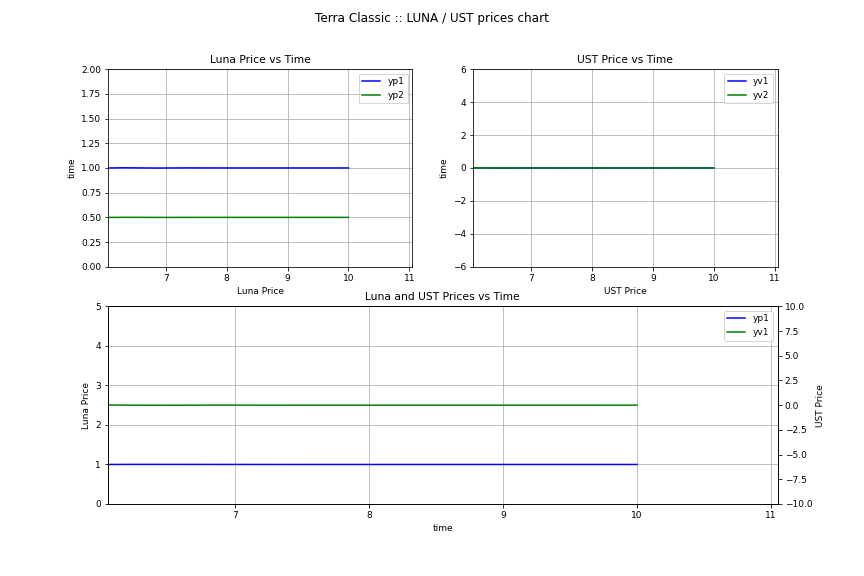

In [77]:
%matplotlib notebook

# Set Font Size for Matplotlib
font = {'size'   : 9}
matplotlib.rc('font', **font)

# Setup figure and subplots
f0 = figure(num = 0, figsize = (12, 8))#, dpi = 100)
f0.suptitle("Terra Classic :: LUNA / UST prices chart", fontsize=12)
ax01 = subplot2grid((2, 2), (0, 0))
ax02 = subplot2grid((2, 2), (0, 1))
ax03 = subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)
ax04 = ax03.twinx() # Create a new Axes with an invisible x-axis and an independent y-axis positioned opposite to the original one (i.e. at right). 
#tight_layout()

# Set titles of subplots
ax01.set_title('Luna Price vs Time')
ax02.set_title('UST Price vs Time')
ax03.set_title('Luna and UST Prices vs Time')

# set y-limits
ax01.set_ylim(0,120)
ax02.set_ylim(1,1.1)
ax03.set_ylim(0,120)
ax04.set_ylim(0,1.1)

# sex x-limits
ax01.set_xlim(7413174,7413174 + 10)
ax02.set_xlim(7413174,7413174 + 10)
ax03.set_xlim(7413174,7413174 + 10)
ax04.set_xlim(7413174,7413174 + 10)

# Turn on grids
ax01.grid(True)
ax02.grid(True)
ax03.grid(True)

# set label names
ax01.set_xlabel("Luna Price")
ax01.set_ylabel("block height")
ax02.set_xlabel("UST Price")
ax02.set_ylabel("block height")
ax03.set_xlabel("block height")
ax03.set_ylabel("Luna Price")
ax04.set_ylabel("UST Price")

# Data Placeholders
yp1=zeros(0)
yv1=zeros(0)
yp2=zeros(0)
yv2=zeros(0)
t=zeros(0)

# set plots (Starting datasets)
p011, = ax01.plot(t,yp1,'b-', label="yp1")
p012, = ax01.plot(t,yp2,'g-', label="yp2")

p021, = ax02.plot(t,yv1,'b-', label="yv1")
p022, = ax02.plot(t,yv2,'g-', label="yv2")

p031, = ax03.plot(t,yp1,'b-', label="yp1")
p032, = ax04.plot(t,yv1,'g-', label="yv1")

# set lagends
ax01.legend([p011,p012], [p011.get_label(),p012.get_label()])
ax02.legend([p021,p022], [p021.get_label(),p022.get_label()])
ax03.legend([p031,p032], [p031.get_label(),p032.get_label()])

# Data Update
xmin = 0.0
xmax = 5.0
x = 0.0

def updateData(self):
    global x
    global yp1
    global yv1
    global yp2
    global yv2
    global t
    
    # Update y-axis datasets
    tmpp1 = 1 + exp(-x) *sin(2 * pi * x)
    tmpv1 = - exp(-x) * sin(2 * pi * x) + exp(-x) * cos(2 * pi * x) * 2 * pi
    yp1=append(yp1,tmpp1)
    yv1=append(yv1,tmpv1)
    yp2=append(yp2,0.5*tmpp1)
    yv2=append(yv2,0.5*tmpv1)
    t=append(t,x)
    
    # Set updated y-axis datasets
    p011.set_data(t,yp1)
    p012.set_data(t,yp2)

    p021.set_data(t,yv1)
    p022.set_data(t,yv2)

    p031.set_data(t,yp1)
    p032.set_data(t,yv1)
    
    # Update x-axis
    x += 0.05
    
    
    if x >= xmax-1.00:
        p011.axes.set_xlim(x-xmax+1.0,x+1.0)
        p021.axes.set_xlim(x-xmax+1.0,x+1.0)
        p031.axes.set_xlim(x-xmax+1.0,x+1.0)
        p032.axes.set_xlim(x-xmax+1.0,x+1.0)

    return p011, p012, p021, p022, p031, p032

# interval: draw new frame every 'interval' ms
# frames: number of frames to draw
simulation = animation.FuncAnimation(f0, updateData, blit=False, frames=200, interval=2, repeat=False)

# Uncomment the next line if you want to save the animation
#simulation.save(filename='sim.mp4',fps=30,dpi=300)

plt.show()


In [50]:
luna_burn_phase.head(100)

,timestamp,BlockHeight,uusd::minted,uluna::burnt,uluna::burnt::ust_worth,Luna_Price_UST,uust_mint::net_profit_in_uust
452860,1651228100,7413321,"45,541.3559930",513.1107210,"45,408.0284071",88.4955752,133.3275859
452863,1651228121,7413324,"40,881.9136980",460.6131670,"40,616.6401900",88.1795031,265.2735080
452865,1651228135,7413326,2.2397780,0.0252060,2.2306195,88.4955752,0.0091585
452873,1651228191,7413334,41.2370810,0.4642930,41.1878386,88.7108757,0.0492424
452876,1651228212,7413337,"53,201.3400590",599.8606060,"53,214.1596751",88.7108757,-12.8196161
452879,1651228233,7413340,"56,354.9592950",635.6999630,"56,393.5004203",88.7108757,-38.5411253
452887,1651228289,7413348,"55,431.7139830",625.9387830,"55,194.7139678",88.1790927,237.0000152
452900,1651228380,7413361,3.3908090,0.0382240,3.3703441,88.1735071,0.0204649
452901,1651228387,7413362,"55,666.3233820",628.3979100,"55,610.4345133",88.4955752,55.8888687
452910,1651228450,7413371,"41,253.0596700",465.1559190,"41,227.9189037",88.6324719,25.1407663


In [ ]:

# numpy array
x = np.linspace(-2, 2, 200)
 
# duration of the video
duration = 2
 
# matplot subplot
fig, ax = plt.subplots()
 
# method to get frames
def make_frame(t):
     
    # clear
    ax.clear()
     
    # plotting line
    ax.plot(x, np.sinc(x**2) + np.sin(x + 2 * np.pi / duration * t), lw = 3)
    ax.set_ylim(-1.5, 2.5)
     
    # returning numpy image
    return mplfig_to_npimage(fig)
 
# creating animation
animation = VideoClip(make_frame, duration = duration)
 
# displaying animation with auto play and looping
animation.ipython_display(fps = 20, loop = True, autoplay = True)

In [59]:
luna_burn_phase.head(10)

,timestamp,BlockHeight,uusd::minted,uluna::burnt,uluna::burnt::ust_worth,Luna_Price_UST,uust_mint::net_profit_in_uust
452860,1651228100,7413321,"45,541.3559930",513.1107210,"45,408.0284071",88.4955752,133.3275859
452863,1651228121,7413324,"40,881.9136980",460.6131670,"40,616.6401900",88.1795031,265.2735080
452865,1651228135,7413326,2.2397780,0.0252060,2.2306195,88.4955752,0.0091585
452873,1651228191,7413334,41.2370810,0.4642930,41.1878386,88.7108757,0.0492424
452876,1651228212,7413337,"53,201.3400590",599.8606060,"53,214.1596751",88.7108757,-12.8196161
452879,1651228233,7413340,"56,354.9592950",635.6999630,"56,393.5004203",88.7108757,-38.5411253
452887,1651228289,7413348,"55,431.7139830",625.9387830,"55,194.7139678",88.1790927,237.0000152
452900,1651228380,7413361,3.3908090,0.0382240,3.3703441,88.1735071,0.0204649
452901,1651228387,7413362,"55,666.3233820",628.3979100,"55,610.4345133",88.4955752,55.8888687
452910,1651228450,7413371,"41,253.0596700",465.1559190,"41,227.9189037",88.6324719,25.1407663


In [61]:
len(luna_burn_phase.index)

24480

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


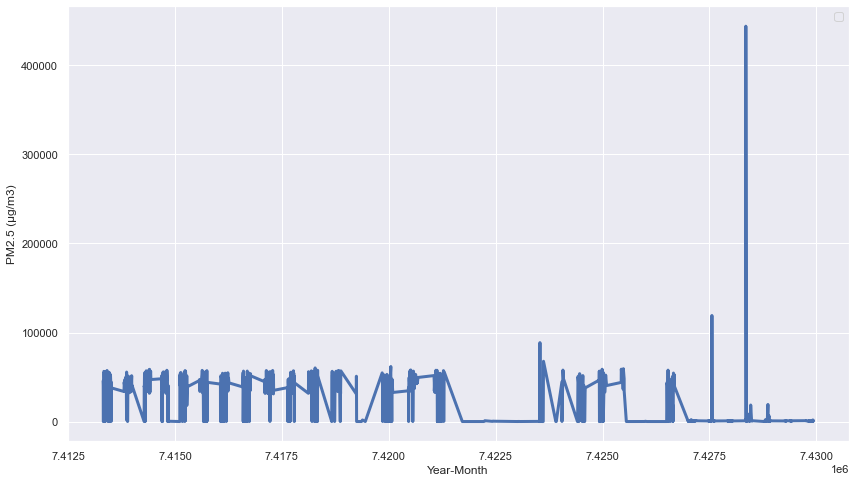

In [62]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=luna_burn_phase[:1000], x ='BlockHeight', y = 'uusd::minted', legend='full', lw=3)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('PM2.5 (µg/m3)')
plt.xlabel('Year-Month')
plt.show()

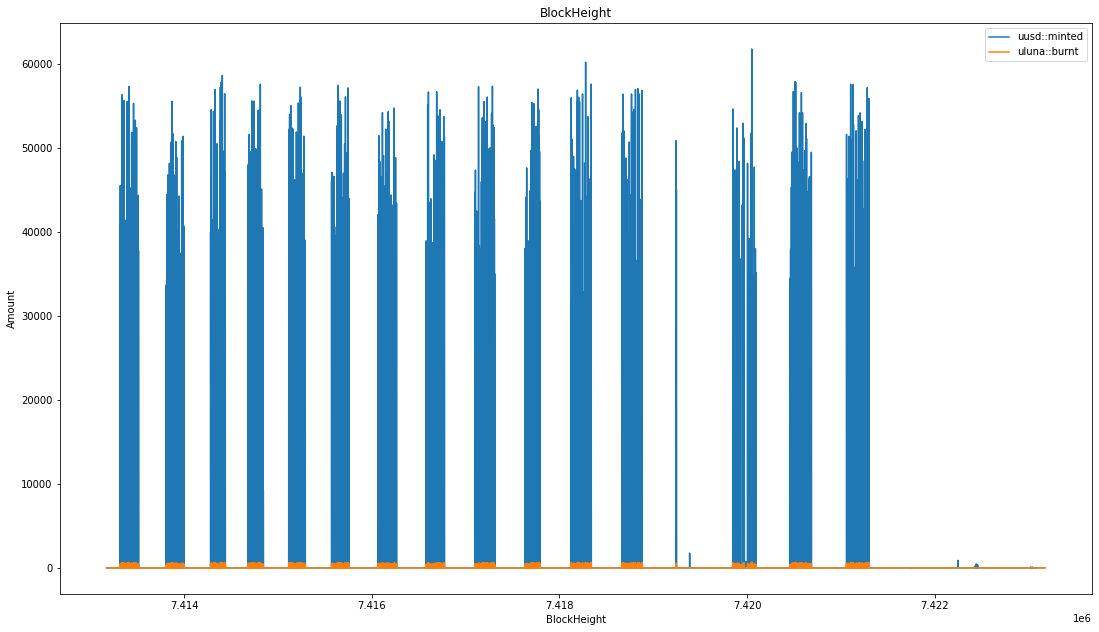

In [44]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(luna_burn_phase["BlockHeight"][:10000], luna_burn_phase["uusd::minted"][:10000] )
plt.plot(luna_burn_phase["BlockHeight"][:10000], luna_burn_phase["uluna::burnt"][:10000] )

plt.xlabel('BlockHeight')
plt.ylabel('Amount')

plt.title('BlockHeight')
plt.legend(['uusd::minted','uluna::burnt'])
# figure(figsize=(18, 16), dpi=180)



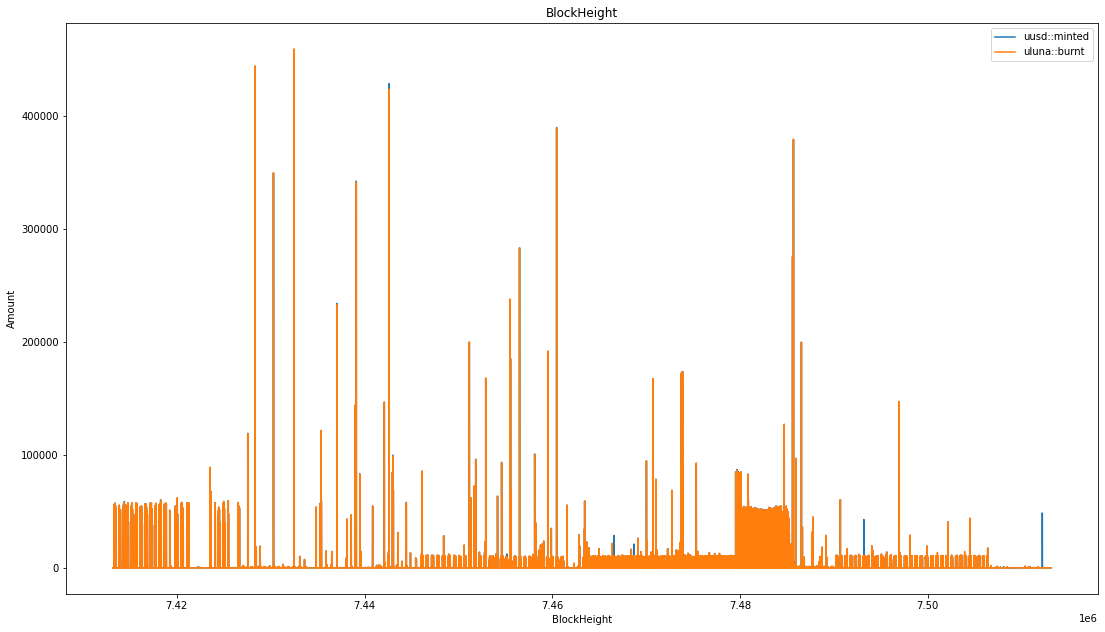

In [109]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(aggregated_vis_market_swap_txs_DF["BlockHeight"][:100000], aggregated_vis_market_swap_txs_DF["uusd::minted"][:100000] )
plt.plot(aggregated_vis_market_swap_txs_DF["BlockHeight"][:100000], aggregated_vis_market_swap_txs_DF["uluna::burnt::ust_worth"][:100000] )

plt.xlabel('BlockHeight')
plt.ylabel('Amount')

plt.title('BlockHeight')
plt.legend(['uusd::minted','uluna::burnt'])
# figure(figsize=(18, 16), dpi=180)



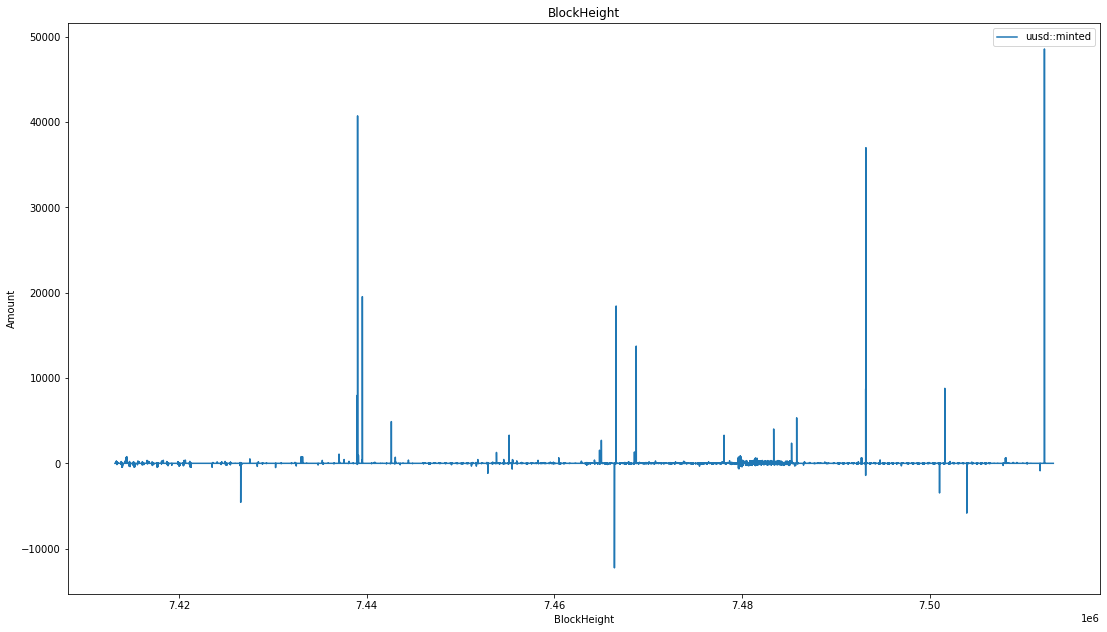

In [110]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

# plt.plot(aggregated_vis_market_swap_txs_DF["BlockHeight"][:10000], aggregated_vis_market_swap_txs_DF["uusd::minted"][:10000] )
plt.plot(aggregated_vis_market_swap_txs_DF["BlockHeight"][:100000], aggregated_vis_market_swap_txs_DF["uust_mint::net_profit_in_uust"][:100000] )

plt.xlabel('BlockHeight')
plt.ylabel('Amount')

plt.title('BlockHeight')
plt.legend(['uusd::minted','uluna::burnt'])
# figure(figsize=(18, 16), dpi=180)



In [112]:
len(aggregated_vis_market_swap_txs_DF.index)

182169

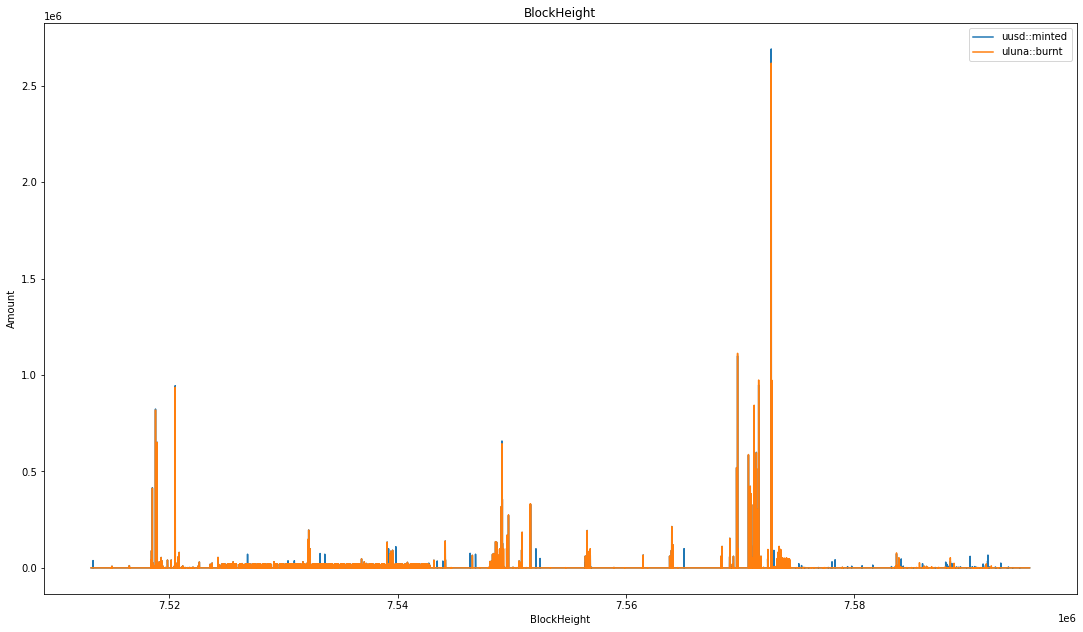

In [111]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(aggregated_vis_market_swap_txs_DF["BlockHeight"][100000:], aggregated_vis_market_swap_txs_DF["uusd::minted"][100000:] )
plt.plot(aggregated_vis_market_swap_txs_DF["BlockHeight"][100000:], aggregated_vis_market_swap_txs_DF["uluna::burnt::ust_worth"][100000:] )

plt.xlabel('BlockHeight')
plt.ylabel('Amount')

plt.title('BlockHeight')
plt.legend(['uusd::minted','uluna::burnt'])
# figure(figsize=(18, 16), dpi=180)



<AxesSubplot:xlabel='BlockHeight'>

<Figure size 1332x756 with 0 Axes>

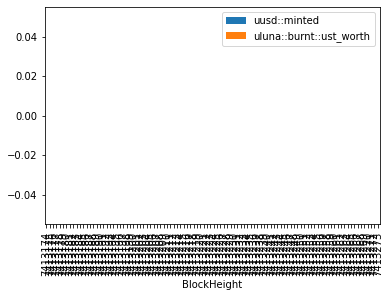

In [115]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

aggregated_vis_market_swap_txs_DF[:100].plot(
    x="BlockHeight", y=["uusd::minted", "uluna::burnt::ust_worth"], kind="bar"
)

In [ ]:
def simulate_terra_classic(terra_classic_instance, astroport_txs_DF, market_swap_txs_DF, exchange_rate_txs_DF, start_height, end_height):
    simulation_metrics_DF = pd.DataFrame(columns=['BlockHeight','burnt_denom', 'tokens_burnt', 'minted_denom',
       'tokens_minted', 'swap_amount', 'swap_fee_amount','spread', 'lunaPool', 'delta','ukrw_oracle_price','usdr_oracle_price'\
                                                 ,'uusd_oracle_price','usd_per_ust_price','usd_per_luna_price', 'expected_profit'])
    
    cur_height = start_height
    prices = {"ukrw": 0, "usdr": 0, "uusd": 0}    
    price_till = 0
    
    # Process all blocks 
    for cur_height in tqdm_notebook(range(start_height,end_height)):
        
        # Oracle Prices
        ukrw_oracle_price = terra_classic_instance.OracleKeeper.GetLunaExchangeRate("ukrw")
        usdr_oracle_price = terra_classic_instance.OracleKeeper.GetLunaExchangeRate("usdr")
        uusd_oracle_price = terra_classic_instance.OracleKeeper.GetLunaExchangeRate("uusd")
        
        # Get UST and LUNA's actual USD Price
        actual_ust_luna_exchange_DF = astroport_txs_DF.loc[ astroport_txs_DF["BlockHeight"] == cur_height ]        
        ust_price_in_usd = 0
        luna_price_in_usd = 0
        if len(actual_ust_luna_exchange_DF.index) > 0 and uusd_oracle_price[0] > 0:
            ust_per_luna_price = actual_ust_luna_exchange_DF.iloc[0]["Price (ust/luna)"]
            ust_price_in_usd = uusd_oracle_price[0] / ust_per_luna_price
            luna_price_in_usd = uusd_oracle_price[0]
                    
        
        # Get all market swap txs to be processed for the current block
        cur_swap_txs_DF = market_swap_txs_DF.loc[ market_swap_txs_DF["BlockHeight"] == cur_height ]
        
        # Loop over all txs for each block
        for tx_row in cur_swap_txs_DF.to_dict(orient='records'):
            try:
                # Process swap tx :: Only UST burn txs are considered
                if tx_row["burnt_denom"] == "uusd" and tx_row["minted_denom"] == "uluna": # or tx_row["burnt_denom"] == "uluna") and (tx_row["minted_denom"] == "uusd" or tx_row["minted_denom"] == "uluna"):
#                     print(f"\nblock {cur_height} :: Burn {tx_row['burnt_denom']} {tx_row['tokens_burnt']} tokens and mint {tx_row['minted_denom']} tokens")
                    swap_response = terra_classic_instance.Swap("trader", {"denom":tx_row["burnt_denom"], "amount":float(tx_row["tokens_burnt"]) }, tx_row["minted_denom"])
                    swapCoin = swap_response["SwapCoin"] 
                    swapFee = swap_response["SwapFee"] 
                    spread = swap_response["spread"] 
                    err = swap_response["Error"] 

                    if err != None:
                        print(err)
                    else:
                        lunaPool = terra_classic_instance.get_LunaPool_fromTerraPool()
                        delta = terra_classic_instance.GetTerraPoolDelta()
                        
                        expected_profit = 0
                        if tx_row["burnt_denom"] == "uusd": # If UST is burnt and LUNA is minted
                            expected_profit = (float(swapCoin["amount"]) * luna_price_in_usd) -  (tx_row['tokens_burnt'] * ust_price_in_usd)
                        else:  # If LUNA is burnt and UST is minted
                            expected_profit = (float(swapCoin["amount"]) * ust_price_in_usd) -  (tx_row['tokens_burnt'] * luna_price_in_usd)

                        # store metrics
                        simulation_metrics_DF.loc[len(simulation_metrics_DF.index)] = [cur_height, tx_row["burnt_denom"],\
                                                    tx_row["tokens_burnt"], tx_row["minted_denom"], float(swapCoin["amount"]) + float(swapFee["amount"]),\
                                                    swapCoin["amount"], swapFee["amount"], spread, lunaPool, delta, ukrw_oracle_price[0],\
                                                    usdr_oracle_price[0], uusd_oracle_price[0], ust_price_in_usd, luna_price_in_usd, expected_profit ]
            except Exception as e:
                print(f"\nblock {cur_height} :: Burn {tx_row['burnt_denom']} {tx_row['tokens_burnt']} tokens and mint {tx_row['minted_denom']} tokens")
                print(e)
            
            
        # Replensih Market module's pool after each block
        terra_classic_instance.TerraMarketModuleEndBlock()
                            
        # Update oracle prices every 5 blocks
        if cur_height%5 == 0 and price_till < cur_height:
            # Get Oracle price from the feed
            cur_price_DF = exchange_rate_txs_DF.loc[ exchange_rate_txs_DF["BlockHeight"] == cur_height ] 
            # If oracle price is 0 here, get the next valid price feed value
            if cur_price_DF.iloc[0]["uusd::mean"] == 0:        
                price_height = cur_height
                while cur_price_DF.iloc[0]["uusd::mean"] == 0:
                    price_height = price_height + 1
                    price_till = price_height
                    cur_price_DF = exchange_rate_txs_DF.loc[ exchange_rate_txs_DF["BlockHeight"] == price_height ] 
                    print(f"while LOOP ||| {price_height} || {cur_price_DF.iloc[0]['uusd::mean']}")
                    
            # Set oracle prices 
            terra_classic_instance.OracleKeeper.SetLunaExchangeRate("ukrw", cur_price_DF.iloc[0]["ukrw::mean"] )
            print(f"{cur_height} || ukrw price = {cur_price_DF.iloc[0]['ukrw::mean']}")
            terra_classic_instance.OracleKeeper.SetLunaExchangeRate("usdr", cur_price_DF.iloc[0]["usdr::mean"] )
            print(f"{cur_height} || usdr price = {cur_price_DF.iloc[0]['usdr::mean']}")
            terra_classic_instance.OracleKeeper.SetLunaExchangeRate("uusd", cur_price_DF.iloc[0]["uusd::mean"] )
            print(f"{cur_height} || uusd price = {cur_price_DF.iloc[0]['uusd::mean']}")
                    
    
    return simulation_metrics_DF






In [ ]:

# CREATE TERRA CLASSIC INSTANCE 
terra_classic_instance = TerraMarketModule(100000000, 0.02, 18)
terra_classic_instance.BankKeeper.MintCoins("trader",{"denom":"uluna", "amount":800 * 10**6 })
terra_classic_instance.BankKeeper.MintCoins("trader",{"denom":"uusd", "amount":18000 * 10**6 })

# Set initial exchange rates
terra_classic_instance.OracleKeeper.SetLunaExchangeRate("uusd", 3.074 )
terra_classic_instance.OracleKeeper.SetLunaExchangeRate("usdr", 2.290 )
terra_classic_instance.OracleKeeper.SetLunaExchangeRate("ukrw", 3916.569 )



In [ ]:
# Get Block heights for which data is available and block height range for which simulation is to be executed

astroport_txs_DF_start_block = astroport_ust_luna_txs_DF.iloc[0]["BlockHeight"]
astroport_txs_DF_end_block = astroport_ust_luna_txs_DF.iloc[len(astroport_ust_luna_txs_DF.index) - 1]["BlockHeight"]
print(f"astroport_txs_DF || Start block = {astroport_txs_DF_start_block}  End block = {astroport_txs_DF_end_block} \
Total Blocks = {astroport_txs_DF_end_block - astroport_txs_DF_start_block}")

market_swap_txs_DF_start_block = market_swap_txs_DF.iloc[0]["BlockHeight"]
market_swap_txs_DF_end_block = market_swap_txs_DF.iloc[len(market_swap_txs_DF.index) - 1]["BlockHeight"]
print(f"market_swap_txs_DF || Start block = {market_swap_txs_DF_start_block}  End block = {market_swap_txs_DF_end_block} \
Total Blocks = {market_swap_txs_DF_end_block - market_swap_txs_DF_start_block}")

oracle_txs_DF_start_block = aggregated_exchange_rate_vote_txs_DF.iloc[0]["BlockHeight"]
oracle_txs_DF_end_block = aggregated_exchange_rate_vote_txs_DF.iloc[len(aggregated_exchange_rate_vote_txs_DF.index) - 1]["BlockHeight"]
print(f"oracle_txs_DF || Start block = {oracle_txs_DF_start_block}  End block = {oracle_txs_DF_end_block} \
Total Blocks = {oracle_txs_DF_end_block - oracle_txs_DF_start_block}")

start_block = int(max(astroport_txs_DF_start_block, max(market_swap_txs_DF_start_block, oracle_txs_DF_start_block)))
end_block = int(min(astroport_txs_DF_end_block, min(market_swap_txs_DF_end_block, oracle_txs_DF_end_block)))
print(f"\nSimulation parameters, Start block = {start_block} End block = {end_block} | Total blocks = {end_block - start_block}")




In [ ]:
# Execute simulation
# simulated_swap_txs_DF = simulate_terra_classic(terra_classic_instance, astroport_ust_luna_txs_DF, market_swap_txs_DF, aggregated_exchange_rate_vote_txs_DF, start_block, end_block)





In [ ]:
simulated_swap_txs_DF.to_csv("./simulated_swap_data/market_swap_txs_DF.csv") 

In [ ]:
# simulated_swap_txs_DF.tail(4000)

In [ ]:
# market_swap_txs_DF.head(4)

In [ ]:
# simulated_swap_txs_DF.head(40)

In [ ]:
# cur_swap_txs_DF = market_swap_txs_DF.loc[ market_swap_txs_DF["BlockHeight"] == 7589925 ]

In [ ]:
# cur_swap_txs_DF

In [ ]:
actual_ust_luna_exchange_DF = astroport_ust_luna_txs_DF.loc[ astroport_ust_luna_txs_DF["BlockHeight"] == 7607375 ]

In [ ]:
# actual_ust_luna_exchange_DF

In [ ]:
actual_ust_luna_exchange_DF.index

In [ ]:
actual_ust_luna_exchange_DF

In [ ]:
actual_ust_luna_exchange_DF.iloc[0]["Price (ust/luna)"]

# TERRA Market Module

A simulated version of terra's market module. Used to simulate on-chain behaviour for analysis. 


### Parameters

The market module contains the following parameters:

| Key                 | Type         | Example                |
|---------------------|--------------|------------------------|
| basepool            | string (dec) | "250000000000.0"       |
| minstabilityspread  | string (dec) | "0.010000000000000000"                                           |
| poolrecoveryperiod  | string (int) | "14400"                |


-------------------------x-------------------------x-------------------------x-------------------------x--------------

## State

### TerraPoolDelta

Market module provides swap functionality based on constant product mechanism. Terra pool have to keep its delta to track the currency demands for swap spread. Luna pool can be retrived from Terra pool delta with following equation:

```go
TerraPool = BasePool + delta
LunaPool = (BasePool * BasePool) / TerraPool
```

> Note that the all pool holds decimal unit of `usdr` amount, so delta is also `usdr` unit.


### Messages

#### MsgSwap

A MsgSwap transaction denotes the Trader's intent to swap their balance of `OfferCoin` for new denomination `AskDenom`, for both Terra<>Terra and Terra<>Luna swaps.


#### MsgSwapSend
A MsgSendSwap first performs a swap of OfferCoin into AskDenom and the sends the resulting coins to ToAddress. Tax is charged normally, as if the sender were issuing a MsgSend with the resutling coins of the swap.


-------------------------x-------------------------x-------------------------x-------------------------x--------------

### Functions

#### ComputeSwap

This function detects the swap type from the offer and ask denominations and returns:

1. The amount of asked coins that should be returned for a given `offerCoin`. This is achieved by first spot-converting `offerCoin` to µSDR and then from µSDR to the desired `askDenom` with the proper exchange rate reported from by the Oracle.

2. The spread % that should be taken as a swap fee given the swap type. Terra<>Terra swaps simply have the Tobin Tax spread fee. Terra<>Luna spreads are the greater of `MinSpread` and spread from Constant Product pricing.


#### ApplySwapToPool

1. This function is called during the swap to update the blockchain's measure of , `TerraPoolDelta`, when the balances of the Terra and Luna liquidity pools have changed.

2. Terra currencies share the same liquidity pool, so `TerraPoolDelta` remains unaltered during Terra<>Terra swaps.

3. For Terra<>Luna swaps, the relative sizes of the pools will be different after the swap, and `delta` will be updated with the following formulas:

    - For Terra to Luna, `delta = delta + offerAmount`
    - For Luna to Terra, `delta = delta - askAmount`


-------------------------x-------------------------x-------------------------x-------------------------x--------------

### End Block

#### Replenish Pool
At each `EndBlock`, the value of `TerraPoolDelta` is decreased depending on `PoolRecoveryPeriod` of parameter.

This allows the network to sharply increase spread fees in during acute price fluctuations, and automatically return the spread to normal after some time when the price change is long term.




In [ ]:
# Market Module implements the logic of swaps between Luna and Terra coins implemented via burn / mint 
# making their total supply dynamic

# Market module provides swap functionality based on constant product mechanism. Terra pool have to keep 
# its delta to track the currency demands for swap spread. 

#---------------x-----------x--------------
class TerraMarketModule:
    
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)    

    def __init__(self, basepool, minstabilityspread, poolrecoveryperiod):
        self.delta = 0
        self.SetParams(basepool, minstabilityspread, poolrecoveryperiod)
    
        self.MicroLunaDenom = "uluna" 
        self.MicroUSDDenom  = "uusd"
        self.MicroKRWDenom  = "ukrw"
        self.MicroSDRDenom  = "usdr"
        self.MicroCNYDenom  = "ucny"
        self.MicroJPYDenom  = "ujpy"
        self.MicroEURDenom  = "ueur"
        self.MicroGBPDenom  = "ugbp"
        self.MicroMNTDenom  = "umnt"
    
        # Keeps track of token balances
        self.BankKeeper = TerraBankModule()
        # Keeps track of oracle prices
        self.OracleKeeper = TerraOracleKeeper()
   
    # SET Parameters
    def SetParams(self, basepool, minstabilityspread, poolrecoveryperiod):
        self.basepool = basepool
        self.minstabilityspread = minstabilityspread
        self.poolrecoveryperiod = poolrecoveryperiod
    
        
    # Luna pool can be retrived from Terra pool delta with following function:
    def get_LunaPool_fromTerraPool(self):
        terraPool = self.basepool + self.delta
        lunaPool = (self.basepool * self.basepool) / terraPool
        return lunaPool

    # GetBasePool returns the basepool
    def GetBasePool(self):
        return self.basepool
    
    # GetMinStabilitySpread returns the minstabilityspread
    def GetMinStabilitySpread(self):
        return self.minstabilityspread

    # GetPoolRecoveryPeriod returns the poolrecoveryperiod
    def GetPoolRecoveryPeriod(self):
        return self.poolrecoveryperiod
    
    # GetTerraPoolDelta returns the gap between the TerraPool and the TerraBasePool
    def GetTerraPoolDelta(self):
        return self.delta

    # SetTerraPoolDelta updates TerraPoolDelta which is gap between the TerraPool and the BasePool
    def _SetTerraPoolDelta(self,delta):
        self.delta = delta

    # USER INTERACTION - SWAP FUNCTION
    def Swap(self, trader,offerCoin, askDenom ) : 
        res = self._handleSwapRequest(trader,offerCoin, askDenom )
        return res        


    # USER INTERACTION - SWAPSEND FUNCTION
    def SwapSend(self, trader, offerCoin, askDenom ): 
        res = self._handleSwapRequest(trader,offerCoin, askDenom )
        return res
        
    # INTERNAL FUNCTION
    # // handleMsgSwap handles the logic of a MsgSwap
    # // This function does not repeat checks that have already been performed
    # // Ex) assert(offerCoin.Denom != askDenom)
    def _handleSwapRequest(self, trader,offerCoin, askDenom ): 

        #  Compute exchange rates between the ask and offer
        (swapDecCoin, spread, err) = self._ComputeSwap(offerCoin, askDenom)
        if err != None:
            return (None, err)

        #  Charge a spread if applicable; the spread is burned
        feeDecCoin : Coin
        if spread > 0:
            feeDecCoin = {"denom" : swapDecCoin["denom"], "amount" : spread * swapDecCoin["amount"]}
        else:
            feeDecCoin = {"denom" : swapDecCoin["denom"], amount : 0 }
        
        # Subtract fee from the swap coin
        swapDecCoin["amount"] = swapDecCoin["amount"] - feeDecCoin["amount"]

        # Update pool delta
        err = self._ApplySwapToPool(offerCoin, swapDecCoin)
        if err != None:
            return (None, err)

        # Send offer coins to module account
        err = self.BankKeeper.SendCoinsFromAccountToModule(trader, "market", offerCoin)
        if err != None:
            return None, err

        # Burn offered coins and subtract from the trader's account
        err = self.BankKeeper.BurnCoins("market", offerCoin)
        if err != None:
            return None, err

        # Mint asked coins and credit Trader's account
        #         swapCoin, decimalCoin = swapDecCoin.TruncateDecimal()
        #         feeDecCoin = feeDecCoin.Add(decimalCoin) # add truncated decimalCoin to swapFee
        #         feeCoin, _ := feeDecCoin.TruncateDecimal()
        mintCoins = { "denom": swapDecCoin["denom"], "amount":swapDecCoin["amount"] + feeDecCoin["amount"] }
        err = self.BankKeeper.MintCoins("market", mintCoins)
        if err != None:
            return None, err

        # Send swap coin to the trader
        err = self.BankKeeper.SendCoinsFromModuleToAccount("market", trader, swapDecCoin)
        if err != None:
            return None, err

        # Send swap fee to oracle account
        if feeDecCoin["amount"] > 0:
            err = self.BankKeeper.SendCoinsFromModuleToModule("market", "oracle", feeDecCoin)
            if err != None:
                return None, err


        return { "SwapCoin": swapDecCoin,
                  "SwapFee":  feeDecCoin,
                    "spread": spread,
                    "Error": None
                }


    
    # INTERNAL FUNCTION
    # // ComputeSwap returns the amount of asked coins should be returned for a given offerCoin at the effective
    # // exchange rate registered with the oracle.
    # // Returns an Error if the swap is recursive, or the coins to be traded are unknown by the oracle, or the amount
    # // to trade is too small.
    def _ComputeSwap(self, offerCoin, askDenom):

        # Return invalid recursive swap err
        if offerCoin["denom"] == askDenom:
            return {"denom":"", "amount":0}, 0, "_ComputeSwap :: offer asset cannot be same as ask asset"

        # Swap offer coin to base denom (usdr) for simplicity of swap process
        baseOfferDecCoin, err = self._ComputeInternalSwap(offerCoin, self.MicroSDRDenom)
        if err != None:
            return {"denom":"", "amount":0}, 0, err
#         else:
#             print(f"{offerCoin['amount']} {offerCoin['denom']} --> {baseOfferDecCoin['amount']} {baseOfferDecCoin['denom']}")

        # Get Ask asset swap amount based on the oracle price
        retDecCoin, err = self._ComputeInternalSwap(baseOfferDecCoin, askDenom)
        if err != None:
            return {"denom":"", "amount":0}, 0, err
#         else:
#             print(f"{baseOfferDecCoin['amount']} {baseOfferDecCoin['denom']} --> {retDecCoin['amount']} {retDecCoin['denom']}")

        # Terra => Terra swap
        # Apply only tobin tax without constant product spread
        if offerCoin["denom"] != self.MicroLunaDenom and askDenom != self.MicroLunaDenom:
            # OfferCoin Toblin Tax
            offerTobinTax, err2 = self.OracleKeeper.GetTobinTax(offerCoin["denom"])
            if err2 != None :
                return {"denom":"", "amount":0}, 0, err2

            # AskAsset Toblin Tax
            askTobinTax, err2 = self.OracleKeeper.GetTobinTax(ctx, askDenom)
            if err2 != None :
                return {"denom":"", "amount":0}, 0, err2

            # Apply highest tobin tax for the denoms in the swap operation
            tobinTax = 0
            if askTobinTax > offerTobinTax:
                tobinTax = askTobinTax
            else :
                tobinTax = offerTobinTax
            
            # Return the computed returnAsset and spread for Terra --> Terra Swap
            spread = tobinTax
            return (retDecCoin, spread, None)

        basePool = self.basepool
        minSpread = self.minstabilityspread

        #  constant-product, which by construction is square of base(equilibrium) pool
        # Calculate current TerraPool and LunaPool values
        cp = basePool*basePool
        terraPoolDelta = self.GetTerraPoolDelta()
        terraPool = basePool + terraPoolDelta
        lunaPool = cp / terraPool
    
#         print(f"terraPool = {terraPool} lunaPool = {lunaPool} terraPoolDelta = {terraPoolDelta}")
    
        # Assign TerraPool / LunaPool to OfferAsset / AskAssets
        offerPool = "" # base denom(usdr) unit
        askPool = ""   # base denom(usdr) unit
        #  Terra->Luna swap
        if offerCoin["denom"] != self.MicroLunaDenom:
            offerPool = terraPool
            askPool = lunaPool
        # Luna->Terra swap
        else:
            offerPool = lunaPool
            askPool = terraPool

        # Get cp(constant-product) based swap amount
        # baseAskAmt = askPool - cp / (offerPool + offerBaseAmount)
        # baseAskAmt is base denom(usdr) unit
        exp_new_ask_pool = cp/(offerPool + baseOfferDecCoin["amount"])
        baseAskAmt = askPool - exp_new_ask_pool
#         print(f"askPool = {askPool} | exp_new_ask_pool = {exp_new_ask_pool} | baseAskAmt = {baseAskAmt} ")

        # Both baseOffer and baseAsk are usdr units, so spread can be calculated by
        # spread = (baseOfferAmt - baseAskAmt) / baseOfferAmt
        baseOfferAmount = baseOfferDecCoin["amount"]
        spread = (baseOfferAmount - baseAskAmt) / baseOfferAmount

        if spread < minSpread:
            spread = minSpread
#         print(f"spread = {spread} ")

        return(retDecCoin, spread, None)



    
    # INTERNAL FUNCTION
    # ComputeInternalSwap returns the amount of asked DecCoin should be returned for a given offerCoin at the effective
    # exchange rate registered with the oracle.
    # Different from ComputeSwap, ComputeInternalSwap does not charge a spread as its use is system internal.
    def _ComputeInternalSwap(self, offerCoin, askDenom):
        if offerCoin["denom"] == askDenom:
            return offerCoin, 0
        
        # Get exchange rate :: OfferAsset --> Luna
        offerRate, err = self.OracleKeeper.GetLunaExchangeRate(offerCoin["denom"])
        if err != None:
            return {"denom":"", "amount":0}, f"ErrNoEffectivePriceFromOracleFor ${offerCoin['denom']}"
        
        # Get exchange rate :: AskAsset --> Luna
        askRate, err = self.OracleKeeper.GetLunaExchangeRate(askDenom)
        if err != None:
            return {"denom":"", "amount":0}, f"ErrNoEffectivePriceFromOracleFor ${askDenom}"
        
        # Calculate return amount
        retAmount = offerCoin["amount"] * askRate / offerRate
        if retAmount < 0:
            return {"denom":"", "amount":0}, "ComputeInternalSwap::Err Return Calc"
        
        # return calc. return amount
        return ({"denom":askDenom,"amount": retAmount}, None)
    
    
    # INTERNAL FUNCTION
    # ApplySwapToPool updates each pool with offerCoin and askCoin taken from swap operation,
    # OfferPool = OfferPool + offerAmt (Fills the swap pool with offerAmt)
    # AskPool = AskPool - askAmt       (Uses askAmt from the swap pool)
    def  _ApplySwapToPool(self, offerCoin, askCoin):
        # No delta update in case Terra to Terra swap
        if offerCoin["denom"] != self.MicroLunaDenom and askCoin["denom"] != self.MicroLunaDenom:
            return None
        # Get Delta
        terraPoolDelta = self.GetTerraPoolDelta()

        # In case swapping Terra to Luna, the terra swap pool(offer) must be 
        # increased and the luna swap pool(ask) must be decreased
        if offerCoin["denom"] != self.MicroLunaDenom and askCoin["denom"] == self.MicroLunaDenom:
            offerBaseCoin, err = self._ComputeInternalSwap(offerCoin, self.MicroSDRDenom)
            if err != None:
                return err
            terraPoolDelta = terraPoolDelta + offerBaseCoin["amount"]

        # In case swapping Luna to Terra, the luna swap pool(offer) must be increased and the terra swap pool(ask) must be decreased
        if offerCoin["denom"] == self.MicroLunaDenom and askCoin["denom"] != self.MicroLunaDenom:
            askBaseCoin, err = self._ComputeInternalSwap(askCoin, self.MicroSDRDenom)
            if err != None:
                return err
            terraPoolDelta = terraPoolDelta - askBaseCoin["amount"]
        
        # Update Terra Delta Variable
        self._SetTerraPoolDelta(terraPoolDelta)

        return None
      
    # EXTERNAL QUERY FUNCTION : DOESN'T IMPACT STATE
    # simulateSwap interface for simulate swap
    def simulateSwap(self, offerCoin, askDenom):
        if askDenom == offerCoin["denom"] :
            return {"denom":"", "amount":0}, "askDenom and offerDenom cannot be same"

        # Invalid amount
        if len(offerCoin["amount"]) > 100 :
            return {"denom":"", "amount":0}, "Invalid offerCoin"
        
        # Calculate Swap
        swapCoin, spread, err = self._ComputeSwap(offerCoin, askDenom)
        if err != None:
            return {"denom":"", "amount":0}, err
        
        # Subtract spread
        if spread > 0:
            swapFeeAmt = spread * swapCoin["amount"]
            if swapFeeAmt > 0:
                swapFee = { "denom":swapCoin["denom"], "amount":swapFeeAmt }
                swapCoin["amount"] = swapCoin["amount"] -  swapFee["amount"]

        return swapCoin, None


    # END--BLOCK FUNCTION    
    # ==> EndBlocker is called at the end of every block
    def TerraMarketModuleEndBlock(self):
        # Replenishes each pools towards equilibrium
        self._ReplenishPools()
    
    # INTERNAL FUNCTION
    # Replenishes each pools towards equilibrium
    def _ReplenishPools(self):
        # Get current pool delta
        poolDelta = self.GetTerraPoolDelta()
        # Calculate Pool Regression Amount with current Pool Recovery period
        poolRegressionAmt = poolDelta / self.poolrecoveryperiod
        # Replenish terra pool towards base pool. 
        # regressionAmt cannot make delta zero
        newPoolDelta = poolDelta - poolRegressionAmt
        # Update Delta
        self._SetTerraPoolDelta(newPoolDelta)
#         print(f"Replenishing pools : poolDelta = {poolDelta} | poolRegressionAmt = {poolRegressionAmt} | newPoolDelta = {newPoolDelta}")

        
        


 



# Bank Module 

Bank Module keeps track of user's token balances and the total supply of these tokens.

In [ ]:
# BankKeeper defines expected supply keeper
#---------------x-----------x--------------
class TerraBankModule:
    
    
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    
    def __init__(self):
        self.accounts = pd.DataFrame(columns=["user_address","uluna","uusd","usdr"])
        self.accounts.loc[0] = ["",0,0,0]
        self.totalSupply = {
        "uluna": 0,
        "uusd": 0,
        "usdr": 0,
    }
        
    # TRANSFER TOKENS
    def SendCoinsFromModuleToModule(self, senderAddr, recipientAddr,  coin):
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"

        # balance check
        sender_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < float(coin["amount"]):
            return "insufficient balance"        
        
        # Get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        
        # Update recepient user balance in the dataframe
        recepient_balance = float(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = recepient_balance + float(coin["amount"])     
        # Update sender user balance in the dataframe
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = sender_balance - float(coin["amount"])     
        
        # LOgging
        new_sender_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        new_recepient_balance = float(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])        
#         print(f"{float(coin['amount'])} {coin['denom']} TRANSFERRED FROM {senderAddr} TO {recipientAddr}")
        return None
    
    
    # TRANSFER TOKENS
    def SendCoinsFromAccountToModule(self, senderAddr, recipientAddr,  coin):
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"

        # balance check
        sender_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < float(coin["amount"]):
            return "insufficient balance"        
        
        # Get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        
        # Update recepient user balance in the dataframe
        recepient_balance = float(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = recepient_balance + float(coin["amount"])     
        # Update sender user balance in the dataframe
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = sender_balance - float(coin["amount"])     
        
        # LOgging
        new_sender_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        new_recepient_balance = float(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])        
#         print(f"{int(coin['amount'])} {coin['denom']} TRANSFERRED FROM {senderAddr} TO {recipientAddr}")
        return None
    
    
    # TRANSFER TOKENS
    def SendCoinsFromModuleToAccount(self, senderAddr, recipientAddr,  coin):
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
#         print(sender)
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"

        # balance check
        sender_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < float(coin["amount"]):
            return "insufficient balance"        
        
        # Get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
#         print(recepient)
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        
        # Update recepient user balance in the dataframe
        recepient_balance = float(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = recepient_balance + float(coin["amount"])     
        # Update sender user balance in the dataframe
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = sender_balance - float(coin["amount"])     
        
        # LOgging
        new_sender_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        new_recepient_balance = float(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])        
#         print(f"{int(coin['amount'])} {coin['denom']} TRANSFERRED FROM {senderAddr} TO {recipientAddr}")
        return None    
    
    
    # MINT NEW TOKENS
    def MintCoins(self, recipientAddr, coin):
        # get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]

        # Update recepient user balance in the dataframe
        cur_balance = float(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = cur_balance + float(coin["amount"])     
        
        # Update total accounted token supply
        self.totalSupply[coin["denom"]] = self.totalSupply[coin["denom"]] + coin["amount"]

        # LOgging
        new_balance = float(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])
#         print(f"{int(coin['amount'])} {coin['denom']} MINTED")
        return None

       
    # BURN TOKENS
    def BurnCoins(self, senderAddr, coin):
        # get sender
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"
        # balance check
        sender_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < float(coin["amount"]):
            return "insufficient balance"                
        
        # Update sender user balance in the dataframe
        cur_balance = float(sender[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = cur_balance - float(coin["amount"])     
        
        # Update total accounted token supply
        self.totalSupply[coin["denom"]] = self.totalSupply[coin["denom"]] - coin["amount"]

        # LOgging
        new_balance = float(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])
#         print(f"{float(coin['amount'])} {coin['denom']} BURNT")
        return None

           
        
    # GET USER BALANCE
    def GetBalance(self, addr, denom):
        user = self.accounts.loc[self.accounts['user_address'] == addr]
        len_ = len(user)
        if len(user) == 0:
            self.accounts.loc[len(self.accounts.index)] = [addr,0,0,0]
            return 0
        return float(user[denom])
        

    def GetTotalSupply(self, denom):
        return self.totalSupply[denom]
    
    
    def SpendableCoins(self,ctx, addr):
        pass

    def IsSendEnabledCoin(self,ctx, coin):
        pass

## ORACLE MODULE

A toned-down version of terra's Oracle module used to update / fetch prices for terraCoins to be used by Terra's market module for processing swaps.



In [ ]:
# OracleKeeper defines expected oracle keeper
#---------------x-----------x--------------
class TerraOracleKeeper:

    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    
    def __init__(self):    
        self.voteperiod = 30                       # core.BlocksPerMinute / 2 (30 seconds) 
        self.rewarddistributionwindow = 5256000    # core.BlocksPerWeek (window for a week)
        self.slashwindow = 100800                  # core.BlocksPerYear (window for a year)

        self.votethreshold = 0.500000000000000000  # 50%
        self.rewardband = 0.02                     # 2%
        
        self.whitelist = {"name": "ukrw", "tobin_tax": 0.002000000000000000}
        self.slashfraction = 0.001000000000000000                 # 0.01%
        self.minvalidperwindow = 0.050000000000000000             # 5%
        
        self.currentExchangeRates = {
            "uusd": 0,
            "usdr": 0,
            "ukrw": 0
        }
        self.toblinTax = {
            "uusd": 0.0035,
            "usdr": 0.0035,
            "ukrw": 0.0035,
            "umnt": 0.02,
            "ueur": 0.0035,
            "ucny": 0.0035,
            "ujpy": 0.0035,
            "ugbp": 0.0035,
            "uinr": 0.0035,
            "ucad": 0.0035,
            "uchf": 0.0035,
            "uhkd": 0.0035,
            "usgd": 0.0035,
            "uaud": 0.0035,
            "uthb": 0.0075,
            "usek": 0.0035,
            "udkk": 0.0035,
            "unok": 0.0035,
            "uidr": 0.0075,
            "uphp": 0.0075,
            "umyr": 0.0035,
            "utwd": 0.0035,
        }
    
        self.MicroLunaDenom = "uluna"
        self.MicroUSDDenom  = "uusd"
        self.MicroKRWDenom  = "ukrw"
        self.MicroSDRDenom  = "usdr"
        self.MicroCNYDenom  = "ucny"
        self.MicroJPYDenom  = "ujpy"
        self.MicroEURDenom  = "ueur"
        self.MicroGBPDenom  = "ugbp"
        self.MicroMNTDenom  = "umnt"    
    
    
    # EXTERNAL FUNCTION
    # get exchange rate
    def GetLunaExchangeRate(self,denom):
        if denom == self.MicroLunaDenom:
            return 1, None
        # retrieve exchange rate
        ex = self.currentExchangeRates[denom]
        if ex == None:
            return 0, "Unknown Denom"    
        return ex, None

    # INTERNAL FUNCTION
    # set exchange rate
    def SetLunaExchangeRate(self, denom, exchangeRate): 
        self.currentExchangeRates[denom] = exchangeRate
       
    
    # INTERNAL FUNCTION
    # delete exchange rate
    def _DeleteLunaExchangeRate(self, denom): 
        self.currentExchangeRates[denom] = 0
           
    # EXTERNAL FUNCTION -- Get Toblin Tax
    def GetTobinTax(self, denom):
        return self.toblinTax[denom]

    # EXTERNAL FUNCTION -- Set Toblin Tax
    def SetTobinTax(self, denom, tobinTax): 
        self.toblinTax[denom] = tobinTax
   

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import csv
# import math

# # https://classic-agora.terra.money/t/seigniorage-distribution-framework/212

# """
# Seigniorage allocation simulation in a 2 firm economy(dappA, dappB)
# Inputs
# Tax Spent(include swap fee), Total Value Locked timeseries data for each firm
# Parameters
# lambda
# alpha
# Outputs
# Funding Weight timeseies for each firm
# """

# class SeigniorageState:
#     def __init__(self, dappA, dappB, λ, α):
#         self.dappA = dappA
#         self.dappB = dappB
#         self.λ = λ
#         self.α = α

#     # tax Spent, total value locked
#     # 1 period = 14days
#     def Wil(self):
#         wil = []
#         j = 0
#         for i in range(0, len(self.dappA), 14):
#             periodic_dappA_fee = 0
#             periodic_dappA_tvl = 0
#             periodic_dappB_fee = 0
#             periodic_dappB_tvl = 0
#             temp_dappA = self.dappA[i : i + 14]
#             temp_dappB = self.dappB[i : i + 14]

#             dappA_wil = 0
#             dappB_wil = 0

#             if len(self.dappA[i : i + 14]) != 14:
#                 break

#             # calculate periodic value
#             for i in range(len(temp_dappA)):
#                 periodic_dappA_fee = periodic_dappA_fee + float(temp_dappA[i][1])
#                 periodic_dappA_tvl = periodic_dappA_tvl + math.sqrt(
#                     float(temp_dappA[i][2])
#                 )
#                 periodic_dappB_fee = periodic_dappB_fee + float(temp_dappB[i][1])
#                 periodic_dappB_tvl = periodic_dappB_tvl + math.sqrt(
#                     float(temp_dappB[i][2])
#                 )

#             # calculate wil value using periodic value
#             dappA_wil = self.λ * (
#                 periodic_dappA_fee / (periodic_dappA_fee + periodic_dappB_fee)
#             ) + (1 - self.λ) * (
#                 periodic_dappA_tvl / (periodic_dappA_tvl + periodic_dappB_tvl)
#             )
#             dappB_wil = self.λ * (
#                 periodic_dappB_fee / (periodic_dappA_fee + periodic_dappB_fee)
#             ) + (1 - self.λ) * (
#                 periodic_dappB_tvl / (periodic_dappA_tvl + periodic_dappB_tvl)
#             )

#             wil.append([j, dappA_wil, dappB_wil])
#             j = j + 1

#         return wil

#     # growth
#     def Wig(self):
#         wig = []
#         j = 0

#         for i in range(0, len(self.dappA), 14):
#             temp_dappA = self.dappA[i : i + 14]
#             temp_dappB = dappB[i : i + 14]
#             periodic_dappA_fee_growth = 0
#             periodic_dappB_fee_growth = 0
#             periodic_dappA_tvl_growth = 0
#             periodic_dappB_tvl_growth = 0

#             if len(self.dappA[i : i + 14]) != 14:
#                 break

#             # calculate the sum of TVL growth rate
#             for i in range(len(temp_dappA)):
#                 try:
#                     periodic_dappA_fee_growth = periodic_dappA_fee_growth + (
#                         (float(temp_dappA[i + 1][1]) - float(temp_dappA[i][1]))
#                         / float(temp_dappA[i][1])
#                     )
#                     periodic_dappA_tvl_growth = periodic_dappA_tvl_growth + (
#                         (
#                             math.sqrt(float(temp_dappA[i + 1][2]))
#                             - math.sqrt(float(temp_dappA[i][2]))
#                         )
#                         / math.sqrt((float(temp_dappA[i][2])))
#                     )
#                     periodic_dappB_fee_growth = periodic_dappB_fee_growth + (
#                         (float(temp_dappB[i + 1][1]) - float(temp_dappB[i][1]))
#                         / float(temp_dappB[i][1])
#                     )
#                     periodic_dappB_tvl_growth = periodic_dappB_tvl_growth + (
#                         (
#                             math.sqrt(float(temp_dappB[i + 1][2]))
#                             - math.sqrt(float(temp_dappB[i][2]))
#                         )
#                         / math.sqrt(float(temp_dappB[i][2]))
#                     )
#                 except:
#                     pass

#             # divide TVL growth rate sum by 13, and take max function
#             periodic_dappA_fee_growth = max(0, periodic_dappA_fee_growth / 13)
#             periodic_dappA_tvl_growth = max(0, periodic_dappA_tvl_growth / 13)
#             periodic_dappB_fee_growth = max(0, periodic_dappB_fee_growth / 13)
#             periodic_dappB_tvl_growth = max(0, periodic_dappB_tvl_growth / 13)

#             # the denominator can't be 0
#             if (
#                 periodic_dappA_fee_growth + periodic_dappB_fee_growth == 0
#                 or periodic_dappA_tvl_growth + periodic_dappB_tvl_growth == 0
#             ):
#                 dappA_wig = 0
#                 dappB_wig = 0

#             # calculate wig using periodic value
#             else:
#                 dappA_wig = self.λ * (
#                     periodic_dappA_fee_growth
#                     / (periodic_dappA_fee_growth + periodic_dappB_fee_growth)
#                 ) + (1 - self.λ) * (
#                     periodic_dappA_tvl_growth
#                     / (periodic_dappA_tvl_growth + periodic_dappB_tvl_growth)
#                 )
#                 dappB_wig = self.λ * (
#                     periodic_dappB_fee_growth
#                     / (periodic_dappA_fee_growth + periodic_dappB_fee_growth)
#                 ) + (1 - self.λ) * (
#                     periodic_dappB_tvl_growth
#                     / (periodic_dappA_tvl_growth + periodic_dappB_tvl_growth)
#                 )

#             wig.append([j, dappA_wig, dappB_wig])

#             j = j + 1

#         return wig

#     def funding_weight(self, wil, wig):
#         w = []

#         for i in range(len(wil)):
#             dappA_w = 0
#             dappB_w = 0
#             dappA_w = self.α * wil[i][1] + (1 - self.α) * wig[i][1]
#             dappB_w = self.α * wil[i][2] + (1 - self.α) * wig[i][2]
#             w.append([dappA_w, dappB_w])

#         w = pd.DataFrame(w)
#         w = w.rename(columns={0: "dappA", 1: "dappB"})

#         return w
    
#     def create_graph(self, w):
#         df = w.divide(w.sum(axis=1), axis=0)
#         ax = df.plot(
#             kind="area",
#             color=["lightcoral", "skyblue"],
#             stacked=True,
#             title="λ={}  α={}".format(λ, α)
#         )

#         ax.set_xlabel("Period (2 weeks)")
#         ax.set_ylabel("Funding Weight")
#         ax.set_xlim(0, 25)

#         return plt.show()
        


# if __name__ == "__main__":
#     with open("dappA.csv", newline="") as f:
#         reader = csv.reader(f)
#         dappA = list(reader)
#         dappA = dappA[1:]

#     with open("dappB.csv", newline="") as g:
#         reader = csv.reader(g)
#         dappB = list(reader)
#         dappB = dappB[1:]

#     # read λ and α from the command line
#     λ = float(input("funding weight parameter lambda :"))
#     α = float(input("funding weight parameter alpha :"))

#     if α < 0 or α > 1 or λ < 0 or λ > 1:
#         raise ValueError("lambda and alpha must be between 0 and 1 inclusive")

#     seign = SeigniorageState(dappA=dappA, dappB=dappB, λ=λ, α=α) 
#     w = seign.funding_weight(seign.Wil(), seign.Wig())
    
#     seign.create_graph(w)